Here are some notes and calculations that arose from thinking about how _good_ various shuffling techniques are for MTG. 

In [24]:
import contextlib
import random
import shutil
from copy import deepcopy
from itertools import permutations
from math import ceil, log10
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

# Setting up a deck

To simulate and visualise shuffling techniques we'll need a way of encoding the order of a deck. To do this I have just used a list with items that are either integers or strings.
- integers are arbitrarily assigned to cards that are not basic lands
- strings are used to denote basic lands by colour

In [25]:
def get_ordered_commander_library(
    n_cards: int, lands: dict[str:int]
) -> list[int|str]:
    """creates list representation of a commander library"""
    library = []
    # add basic lands
    for land, number in lands.items():
        library.extend([land]*number)
    # add other cards
    library.extend([*range(1, n_cards - len(library))])
    return library

def get_commander_library(
    n_cards: int, lands: dict[str:int], seed: int = 0
) -> list[int|str]:
    """returns a randomly shuffled commander library"""
    random.seed(seed)
    library = get_ordered_commander_library(n_cards, lands)
    random.shuffle(library)
    return library

In [26]:
# let's create a function to visualise deck order
def visualise(library: list, title: str = None, ax = None) -> None:
    """visualises library order"""
    if ax is None:
        fig, ax = plt.subplots()

    # create a bar axis with the card indecies of unique cards and a fixed
    # index for land original position doesn't matter for it.
    # land_height = max([val for val in library if isinstance(val, int)]) + 1
    land_height = -10
    bar_colours = []
    bar_heights = []
    for card in library:
        if isinstance(card, int):
            bar_colours.append('tab:purple')
            bar_heights.append(card)
        else:
            bar_colours.append(f'tab:{card}')
            bar_heights.append(land_height)
    bar_indecies = list(range(1, len(library) + 1))
    ax.bar(bar_indecies, bar_heights, color=bar_colours, width=1)

    # set up the axis labels and plot title
    ax.set_ylabel('card index')
    y_vals, y_labels = ax.get_yticks(), ax.get_yticklabels()
    for y, label in zip(y_vals, y_labels):
        if y == land_height:
            label.set_text('land')
            break
    ax.set_yticks(y_vals[1:-1])
    ax.set_yticklabels(y_labels[1:-1])
    ax.set_xlabel('current index')
    if title is not None:
        ax.set_title(title)

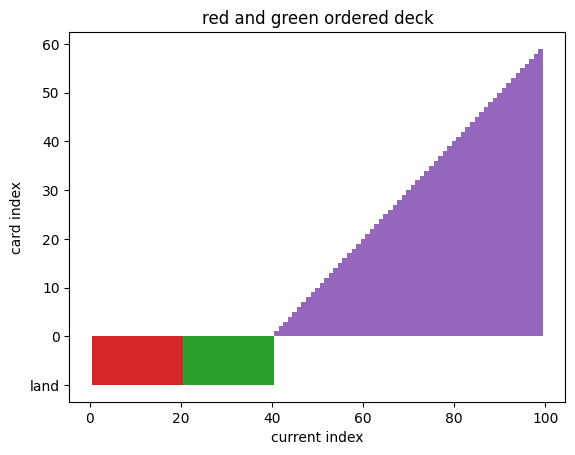

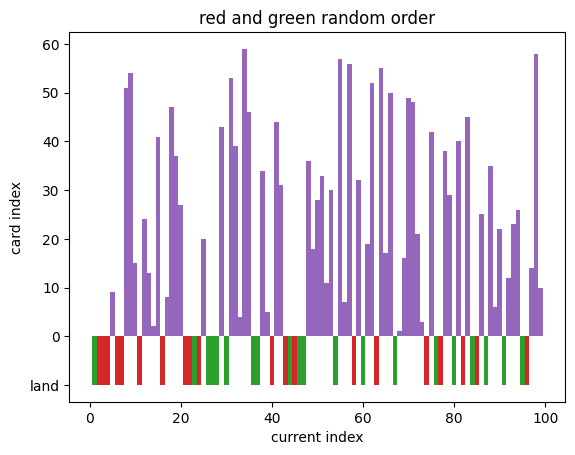

In [27]:
n_cards = 100
lands = {
    'white': 0,
    'black': 0,
    'red': 20,
    'green': 20,
    'blue': 0,
}

# generate some decks to visualise
ordered_deck = get_ordered_commander_library(n_cards, lands)
random_order = get_commander_library(n_cards, lands)

visualise(ordered_deck, title='red and green ordered deck')
visualise(random_order, title='red and green random order')

# Shuffling techniques

Let's create some shuffling techniques to test out.

## Basic shuffle

_Edit: apparently this is officially an "overhand" shuffle_

The simplest shuffle involves the following steps:
- picking up the whole libary
- dropping a chunk from the top of the cards picked up into the other hand
- repeating the previous step until no cards are picked up

This shuffle can be repeated until a deck is sufficiently shuffled. But how many times is required?

In [28]:
def basic_shuffle(library: list[int|str], seed: int = 0) -> list[int|str]:
    """
    returns a copy of the library passed with one iteration of basic shuffling
    """
    random.seed(seed)
    shuffled = []
    index = 0
    while len(shuffled) < len(library):
        next_index = random.randint(index, len(library))
        shuffled = library[index: next_index] + shuffled
        index = next_index
    return deepcopy(shuffled)


iterating shuffle: 10it [00:01,  7.34it/s]


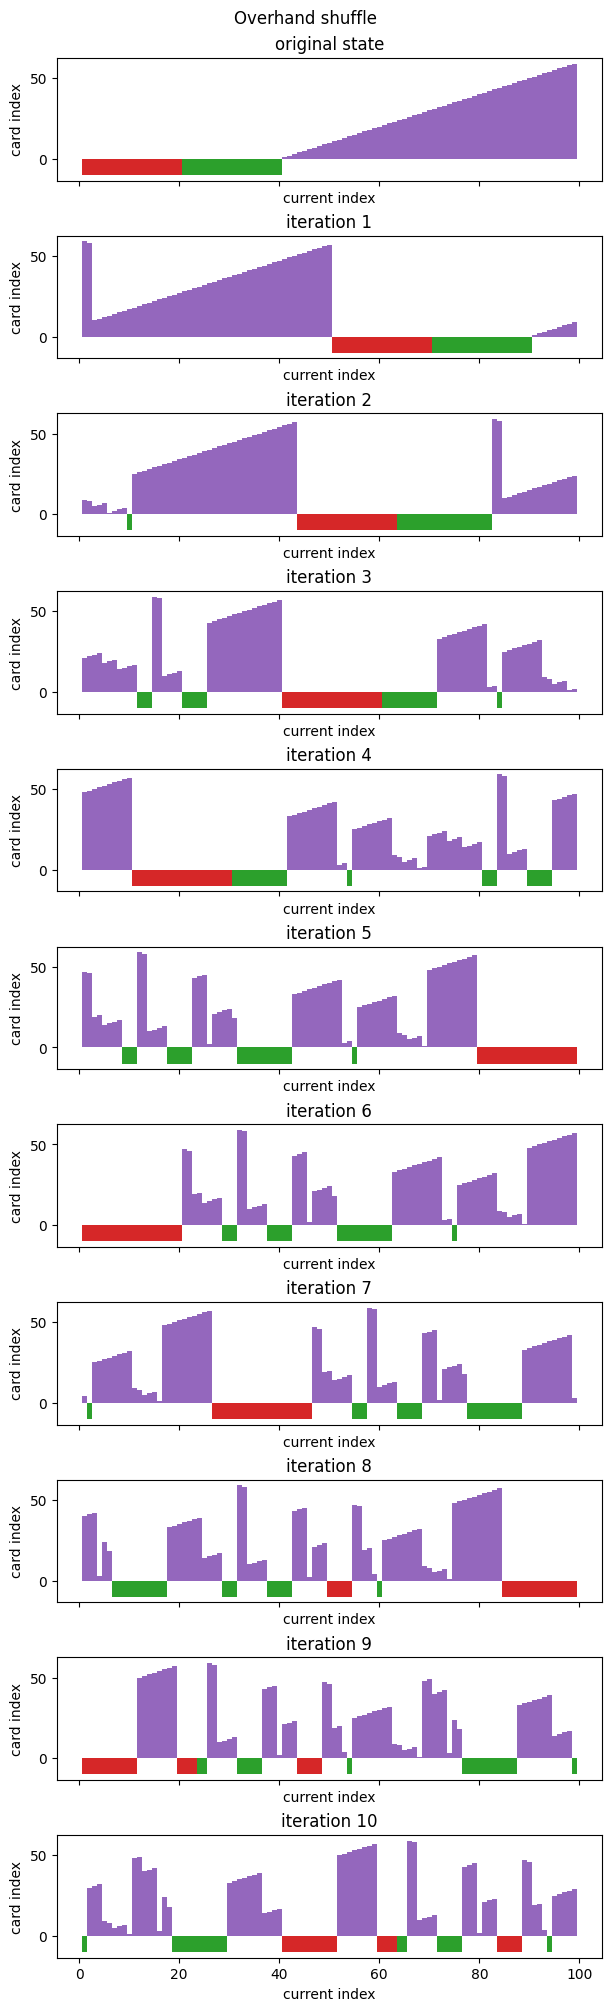

In [29]:
# let's see what this shuffle looks like on an ordered deck
def visualise_shuffle_iterations(
    library: list[int|str], shuffle: callable, n_iterations: int,
    title: str = None
) -> tuple[plt.Figure, plt.Axes]:
    fig, _ = plt.subplots(nrows=n_iterations + 1, sharex=True, constrained_layout=True)
    ax = fig.axes[0]
    visualise(library, ax=ax, title='original state')

    shuffled = library
    for ax, iteration in tqdm(
        zip(fig.axes[1:], range(n_iterations)),
        desc='iterating shuffle'
    ):
        shuffled = shuffle(shuffled, seed=iteration)
        visualise(shuffled, ax=ax, title=f'iteration {iteration + 1}')
    if title is not None:
        fig.suptitle(title)
    fig.set_size_inches(6, 20)

visualise_shuffle_iterations(
    ordered_deck, basic_shuffle, 10, 'Overhand shuffle')

In [30]:
# let's make some gifs
def create_gif(image_paths: list, gif_name: Path, duration: int) -> None:
    """creates a gif with the images passed"""
    with contextlib.ExitStack() as stack:
        images = (
            stack.enter_context(Image.open(file))
            for file in sorted(image_paths)
        )
        image = next(images)
        image.save(
            fp=gif_name, format='GIF', append_images=images, save_all=True,
            duration=duration, loop=0)

def create_shuffle_images(
        library: list, shuffle: callable, n_iterations: int,
        initial_seed: int = 0, title: str = None
) -> Path:
    """creates a gif of library visualisations"""

    # create temp directory for putting images into
    image_path = Path('img_temp')
    image_path.mkdir(exist_ok=True)

    def i_str(value: int) -> str:
        """formats a string with the right number of leading 0s"""
        return f'{value:0{ceil(log10(n_iterations + 1))}d}'

    # create images
    figure_title = f'iteration: {i_str(0)}'
    if title is not None:
        figure_title = ', '.join((title, figure_title))

    fig, ax = plt.subplots()
    visualise(library, title=figure_title, ax=ax)
    fig.savefig(image_path / f'temp_{i_str(0)}.png')
    plt.close(fig)

    shuffled_library = deepcopy(library)
    for iteration in tqdm(
            range(1, n_iterations + 1), desc='generating images'):
        shuffled_library = shuffle(
            shuffled_library, seed=initial_seed + iteration)

        figure_title = f'iteration: {i_str(iteration)}'
        if title is not None:
            figure_title = ', '.join((title, figure_title))

        fig, ax = plt.subplots()
        visualise(shuffled_library, title=figure_title, ax=ax)
        fig.savefig(image_path / f'temp_{i_str(iteration)}.png')
        plt.close(fig)

    return image_path

def create_shuffle_gif(
    library: int, shuffle: callable, n_iterations: int, filename: Path,
    initial_seed: int = 0, frame_duration_ms: int = 300, title: str = None
) -> None:
    """creates a shuffle gif"""
    image_path = create_shuffle_images(
        library, shuffle, n_iterations, initial_seed=initial_seed, title=title)
    create_gif(image_path.glob('*.png'), filename, frame_duration_ms)
    shutil.rmtree(image_path)


# Riffle shuffle

Now, I wouldn't really want to do a riffle shuffle to my library but since no cards are harmed in the making of this notebook we can safely try it out.

I would define a riffle shuffle as follows:
- cut the library into 2 sections
- interlace the two sections

iterating shuffle: 10it [00:01,  8.40it/s]


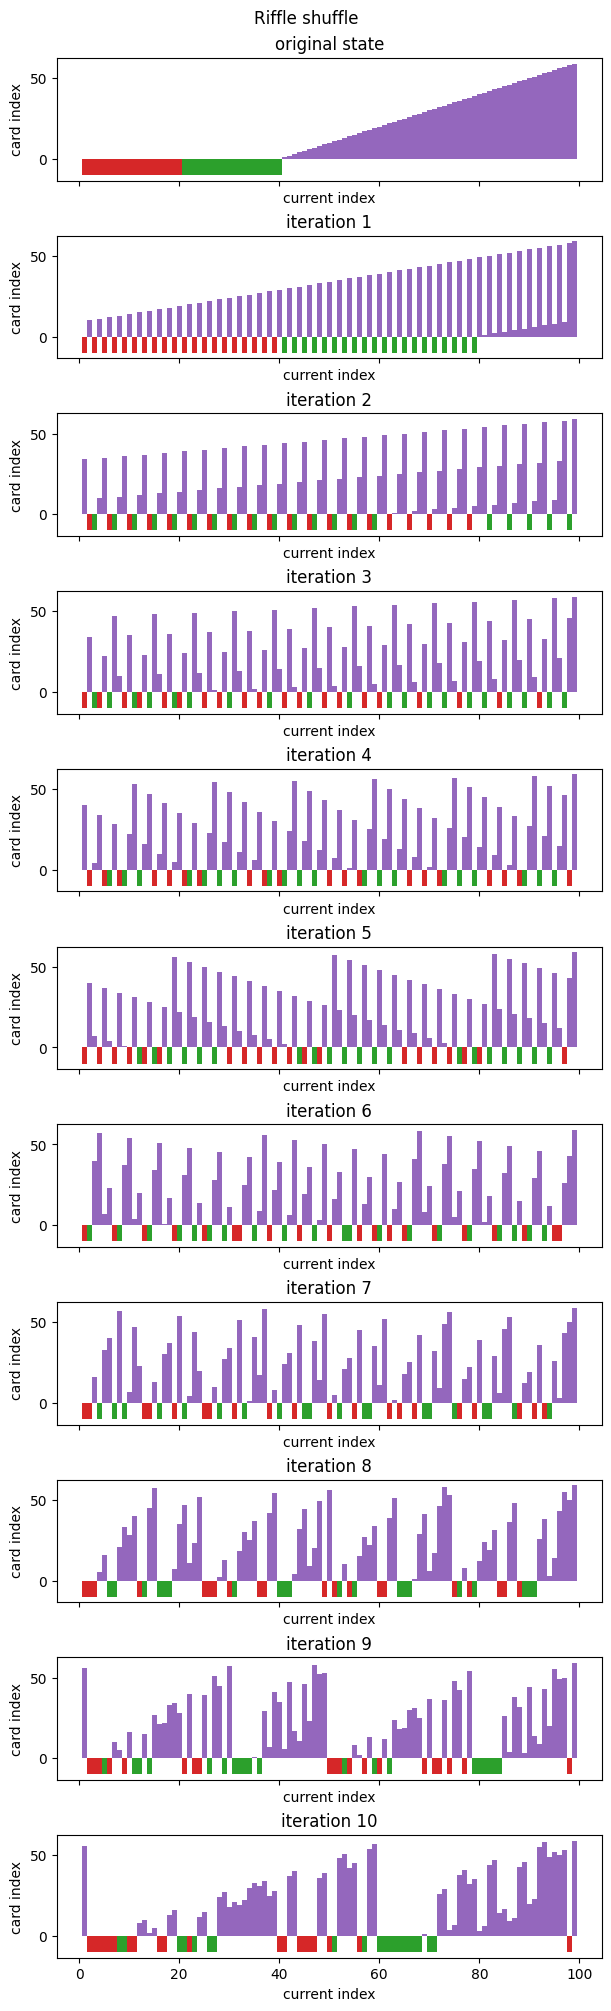

In [31]:
def riffle_shuffle(library: list, seed: int = 0) -> list:
    """returns a copy of the library with a riffle shuffle performed"""
    # split library into 2
    half_way = len(library) // 2
    lib_copy = deepcopy(library)
    top, bottom = lib_copy[:half_way], lib_copy[half_way:]

    # randomly choose one section to pop from first
    random.seed(seed)
    if random.randint(0, 1):
        first, second = top, bottom
    else:
        first, second = bottom, top

    # fill shuffled library
    shuffled = []
    while len(top) > 0 or len(bottom) > 0:
        try:
            shuffled.append(first.pop(0))
        except IndexError:
            pass
        try:
            shuffled.append(second.pop(0))
        except IndexError:
            pass
    
    return shuffled

visualise_shuffle_iterations(ordered_deck, riffle_shuffle, 10, 'Riffle shuffle')

## Pile shuffle

The library is dealt into piles which are then re-assembled. If none of these steps are done randomly it is essentially an $n^{th}$ order riffle shuffle.

In [32]:
def pile_shuffle(
    library: list, n_piles: int, random_allocation: bool,
    random_assembly: bool,
    allocation_seed: int = 0, assembly_seed: int = 0
) -> list:
    """returns a copy of the library with pile shuffle performed"""
    # create the piles
    pile_indecies = list(range(n_piles))
    piles = [list() for _ in pile_indecies]

    # pop a cards off the library one by one
    random.seed(allocation_seed)
    lib_copy = deepcopy(library)
    while len(lib_copy) > 0:
        if random_allocation:
            random.shuffle(pile_indecies)
        for pile_index in pile_indecies:
            try:
                piles[pile_index].append(lib_copy.pop(0))
            except IndexError:
                break
    
    # re-assemble the piles
    shuffled = []
    pile_indecies = list(range(n_piles))
    if random_assembly:
        random.seed(assembly_seed)
        random.shuffle(pile_indecies)
    for pile_index in pile_indecies:
        shuffled.extend(piles[pile_index])
    
    return shuffled

print(pile_shuffle(list(range(10)), 4, False, False))
    

[0, 4, 8, 1, 5, 9, 2, 6, 3, 7]


iterating shuffle: 10it [00:00, 10.48it/s]


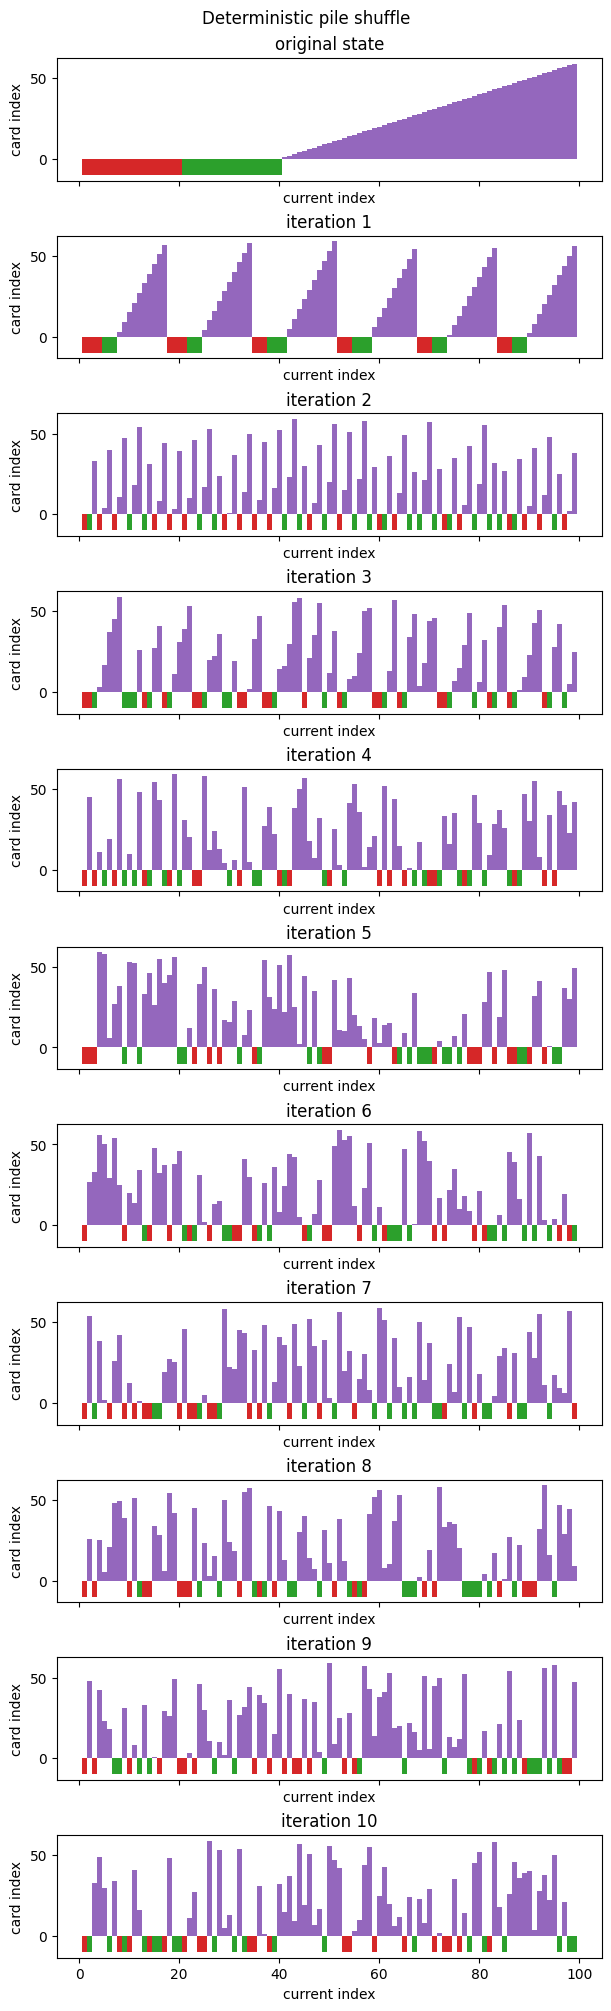

In [33]:
def pile_shuffle_6_det(library: int, *args, **kwargs) -> list:
    """pile shuffle with 6 piles which is deterministic"""
    return pile_shuffle(library, 6, False, False)

visualise_shuffle_iterations(
    ordered_deck, pile_shuffle_6_det, 10, 'Deterministic pile shuffle')

iterating shuffle: 10it [00:01,  9.69it/s]


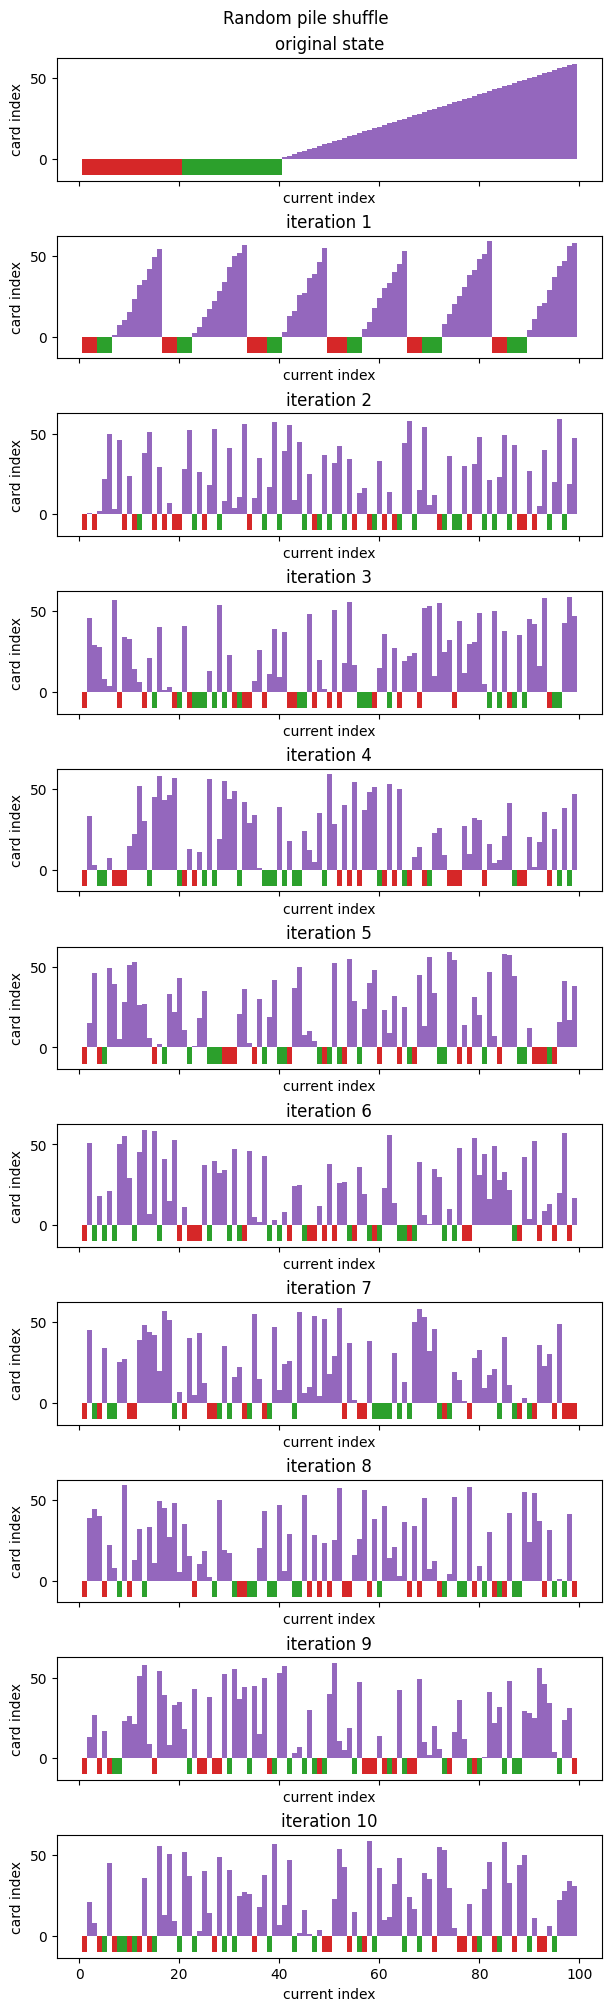

In [34]:
def pile_shuffle_6_rand(library: int, seed: int = 0) -> list:
    """pile shuffle with 6 piles which is deterministic"""
    return pile_shuffle(
        library, 6, True, True, allocation_seed=seed, assembly_seed=seed)

visualise_shuffle_iterations(
    ordered_deck, pile_shuffle_6_rand, 10, title='Random pile shuffle')